In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Setup & Imports

In [2]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import warnings
from collections import Counter
import zipfile
import base64
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, Javascript, display

warnings.filterwarnings("ignore")



## 2. Configuration & Device Setup

This cell configures the training hyperparameters and checks GPU availability:
- **Device**: CUDA GPU if available, otherwise CPU
- **Batch Size**: 16 samples per batch
- **Epochs**: 65 training iterations
- **Image Size**: 224x224 pixel resolution

Memory is also cleared to ensure clean GPU state before training.

In [3]:
gc.collect()
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16     
EPOCHS = 60

IMAGE_SIZE = 224     
DATA_PATH = "/kaggle/input/cs-776-competition-2025-2026-sem-2/dataset_music"

print(f" Model running on: {DEVICE}")
print(f" Resolution: {IMAGE_SIZE}x{IMAGE_SIZE}")

 Model running on: cuda
 Resolution: 224x224


## 3. Data Exploration


Visualizations show class imbalance and sample images from all three input types.

Training Data Shape: (21825, 5)

First few rows:
   id                                   input_1  \
0   0  ./dataset_music/train/input_1/000000.jpg   
1   1  ./dataset_music/train/input_1/000001.jpg   
2   2  ./dataset_music/train/input_1/000002.jpg   
3   3  ./dataset_music/train/input_1/000003.jpg   
4   4  ./dataset_music/train/input_1/000004.jpg   

                                    input_2  \
0  ./dataset_music/train/input_2/000000.jpg   
1  ./dataset_music/train/input_2/000001.jpg   
2  ./dataset_music/train/input_2/000002.jpg   
3  ./dataset_music/train/input_2/000003.jpg   
4  ./dataset_music/train/input_2/000004.jpg   

                                    input_3  target  
0  ./dataset_music/train/input_3/000000.jpg      11  
1  ./dataset_music/train/input_3/000001.jpg       0  
2  ./dataset_music/train/input_3/000002.jpg      10  
3  ./dataset_music/train/input_3/000003.jpg      13  
4  ./dataset_music/train/input_3/000004.jpg       5  

Class distribution:
target
0     227

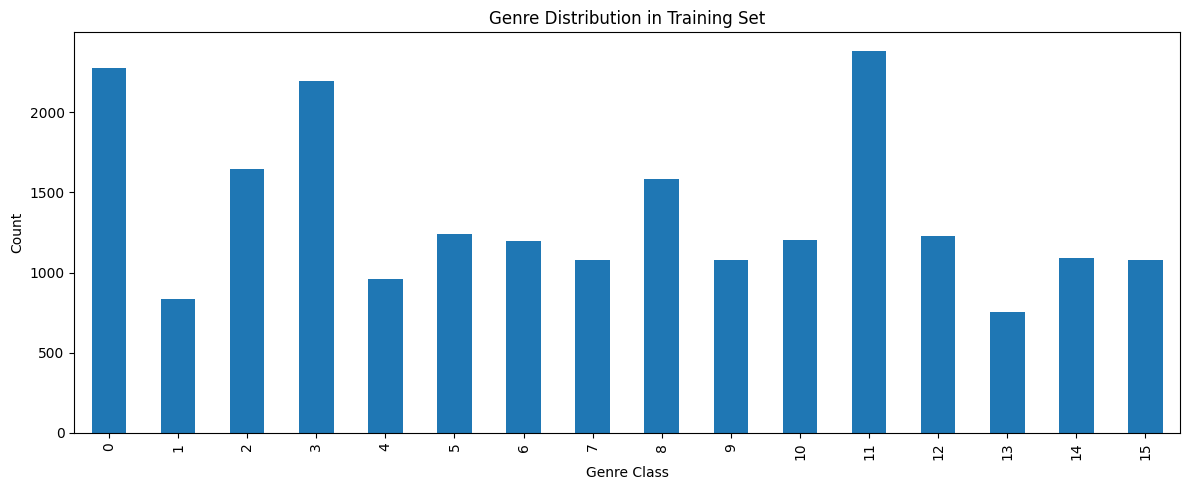

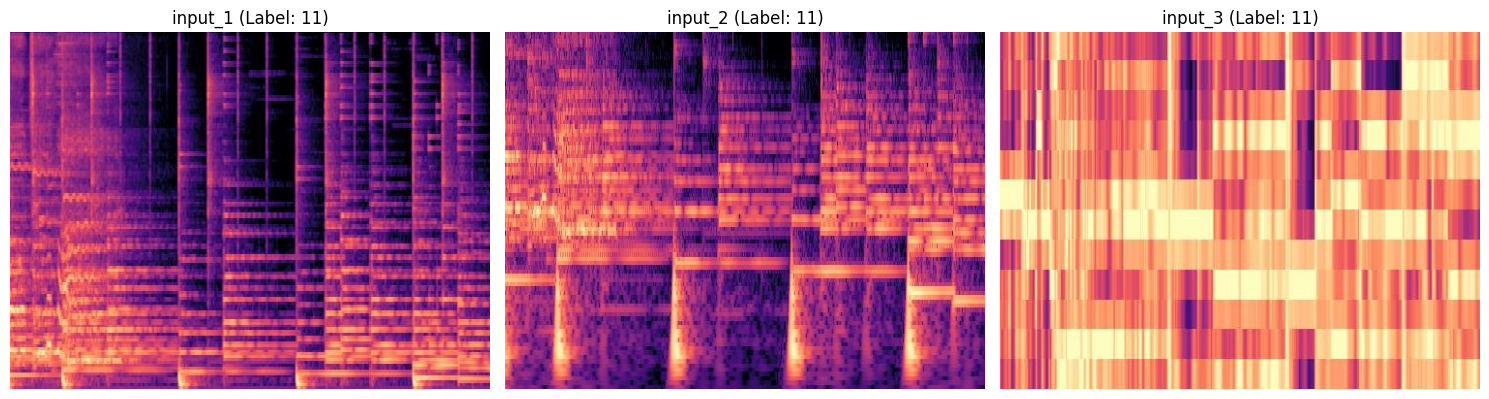

In [4]:
# Load metadata
train_df = pd.read_csv('/kaggle/input/cs-776-competition-2025-2026-sem-2/dataset_music/train/metadata.csv')
test_df = pd.read_csv('/kaggle/input/cs-776-competition-2025-2026-sem-2/dataset_music/test/metadata.csv')

print("Training Data Shape:", train_df.shape)
print("\nFirst few rows:")
print(train_df.head())
print("\nClass distribution:")
print(train_df['target'].value_counts().sort_index())

# Visualize class distribution
plt.figure(figsize=(12, 5))
train_df['target'].value_counts().sort_index().plot(kind='bar')
plt.title('Genre Distribution in Training Set')
plt.xlabel('Genre Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Sample visualization of three inputs
sample_idx = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, input_type in enumerate(['input_1', 'input_2', 'input_3']):
    img_path = f"/kaggle/input/cs-776-competition-2025-2026-sem-2/dataset_music/train/{input_type}/{sample_idx:06d}.jpg"
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'{input_type} (Label: {train_df.iloc[sample_idx]["target"]})')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 4. Custom Layer Implementations

All neural network layers are implemented from scratch without using torch.nn predefined modules, as required by the competition rules.

### Custom Layers Implemented:

1. **CustomLinear**: Fully connected layer with weight matrix and bias
   - Implements: y = xW^T + b
   - Uses Xavier initialization for stable gradients

2. **CustomBatchNorm2d**: 2D Batch Normalization for convolutional features
   - Normalizes activations across batch dimension
   - Maintains running statistics for inference
   - Learnable scale (gamma) and shift (beta) parameters

3. **CustomMaxPool2d**: 2x2 Max Pooling operation
   - Downsamples spatial dimensions by factor of 2
   - Selects maximum value in each 2x2 window

4. **CustomConv2d**: 2D Convolution layer
   - Implements convolution using unfold/matrix multiplication
   - Supports custom kernel size, stride, and padding
   - Uses weight sharing across spatial locations

5. **CustomDropout**: Regularization layer
   - Randomly zeros elements during training
   - Scales remaining elements to maintain expected value

6. **CustomBatchNorm1d**: 1D Batch Normalization for fully connected layers
   - Normalizes features in classification head
   - Improves convergence and generalization

In [5]:
# Linear Layer
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))
    def forward(self, x):
        return x @ self.weight.t() + self.bias

# BatchNorm2d layer
class CustomBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.weight = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.register_buffer('running_mean', torch.zeros(1, num_features, 1, 1))
        self.register_buffer('running_var', torch.ones(1, num_features, 1, 1))

    def forward(self, x):
        if self.training:
            # Manual Mean/Var Calculation
            mean = x.mean(dim=(0, 2, 3), keepdim=True)
            var = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
            x_norm = (x - mean) / torch.sqrt(var + self.eps)
        else:
            x_norm = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
        return x_norm * self.weight + self.bias

# MaxPool2d Layer
class CustomMaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__()
    def forward(self, x):
        b, c, h, w = x.shape
        x = x[:, :, :h//2*2, :w//2*2]
        x = x.reshape(b, c, h//2, 2, w//2, 2)
        x = x.max(dim=5)[0] 
        x = x.max(dim=3)[0] 
        return x


# Conv2d Layer
class CustomConv2d(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=1):
        super().__init__()
        self.k = k if isinstance(k, tuple) else (k, k)
        self.s = s if isinstance(s, tuple) else (s, s)
        self.p = p if isinstance(p, tuple) else (p, p)
        self.weight = nn.Parameter(torch.randn(out_c, in_c, self.k[0], self.k[1]) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_c))

    def forward(self, x):
        B, C, H, W = x.shape
        if self.p[0] > 0 or self.p[1] > 0: 
            x = F.pad(x, (self.p[1], self.p[1], self.p[0], self.p[0]))
        patches = F.unfold(x, kernel_size=self.k, stride=self.s)
        out = (self.weight.view(self.weight.shape[0], -1) @ patches) + self.bias.view(-1, 1)
        h_out = (H + 2*self.p[0] - self.k[0]) // self.s[0] + 1
        w_out = (W + 2*self.p[1] - self.k[1]) // self.s[1] + 1
        return out.view(B, -1, h_out, w_out)

# Dropout
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0:
            return x
        # Bernoulli mask: 1 with probability (1-p)
        mask = (torch.rand_like(x) > self.p).float()
        return (x * mask) / (1 - self.p)

# BatchNorm1D
class CustomBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.eps = eps
        self.momentum = momentum

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta

        
print("Custom layers implemented successfully")

Custom layers implemented successfully


## 5. Custom Activation Function

### Mish Activation Function

Implements the Mish activation: f(x) = x * tanh(softplus(x))

**Advantages over ReLU:**
- **Smooth and non-monotonic**: Better gradient flow
- **Self-regularizing**: Reduces overfitting
- **Unbounded above, bounded below**: Prevents dying neurons
- **Empirically better performance**: Especially for deeper networks

This activation has shown superior results in image classification tasks compared to ReLU and Swish.

In [6]:
def custom_mish(x):
    return x * torch.tanh(F.softplus(x))

print("Custom Activation Fucntion implemented successfully")

Custom Activation Fucntion implemented successfully


## 6. Model Architecture

### CompliantDeepCNN: Single-Branch Feature Extractor

Each input stream is processed by an identical CNN backbone with:
- **Block 1**: 3,24 channels, 224x224 to 112x112
- **Block 2**: 24,48 channels, 112x112 to 56x56
- **Block 3**: 48,84 channels, 56x56m to 28x28
- **Global Average Pooling**: 28x28 to 1x1 (84 features)

**Design rationale:**
- Progressive channel expansion captures hierarchical features
- Dual convolutions per block for deeper representations
- BatchNorm after each conv for training stability
- Mish activation for smooth gradients

### CompliantDiamondModel: Multi-Input Fusion Architecture

**Three-branch parallel processing:**
- Branch 1: Processes first input type
- Branch 2: Processes second input type
- Branch 3: Processes third input type

**Fusion strategy:**
- Concatenates 84 features from each branch to 252 features
- Fusion FC layer: 252 to 256 with BatchNorm and Dropout (0.3)
- Classification head: 256 to 16 genres

**Total Parameters: 482,384** (well under 500K limit)

**Advantage of "Diamond" architecture:**
- Three parallel branches that converge (like diamond shape)
- Each branch specializes in different audio characteristics
- Late fusion allows specialized feature learning before combination

In [7]:
class CompliantDeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1 & 2 remain the same to preserve feature extraction
        self.conv1_1 = CustomConv2d(3, 24, k=3, p=1); self.bn1_1 = CustomBatchNorm2d(24)
        self.conv1_2 = CustomConv2d(24, 24, k=3, p=1); self.bn1_2 = CustomBatchNorm2d(24)
        self.pool1 = CustomMaxPool2d(2, 2)
        self.conv2_1 = CustomConv2d(24, 48, k=3, p=1); self.bn2_1 = CustomBatchNorm2d(48)
        self.conv2_2 = CustomConv2d(48, 48, k=3, p=1); self.bn2_2 = CustomBatchNorm2d(48)
        self.pool2 = CustomMaxPool2d(2, 2)
        # Block 3: Reduced to 84 to stay under 500k limit
        self.conv3_1 = CustomConv2d(48, 84, k=3, p=1); self.bn3_1 = CustomBatchNorm2d(84)
        self.conv3_2 = CustomConv2d(84, 84, k=3, p=1); self.bn3_2 = CustomBatchNorm2d(84)
        self.pool3 = CustomMaxPool2d(2, 2)
    def forward(self, x):
        x = custom_mish(self.bn1_1(self.conv1_1(x)))
        x = self.pool1(custom_mish(self.bn1_2(self.conv1_2(x))))
        x = custom_mish(self.bn2_1(self.conv2_1(x)))
        x = self.pool2(custom_mish(self.bn2_2(self.conv2_2(x))))
        x = custom_mish(self.bn3_1(self.conv3_1(x)))
        x = self.pool3(custom_mish(self.bn3_2(self.conv3_2(x))))
        return x.mean(dim=(2, 3))


In [8]:
class CompliantDiamondModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1, self.b2, self.b3 = CompliantDeepCNN(), CompliantDeepCNN(), CompliantDeepCNN()
        # Smarter Fusion Head
        self.fusion_fc = CustomLinear(84 * 3, 256)
        self.fusion_bn = CustomBatchNorm1d(256)
        self.fusion_drop = CustomDropout(p=0.3)
        self.fc_final = CustomLinear(256, 16) 
        
    def forward(self, x1, x2, x3):
        combined = torch.cat([self.b1(x1), self.b2(x2), self.b3(x3)], dim=1)
        x = self.fusion_drop(custom_mish(self.fusion_bn(self.fusion_fc(combined))))
        return self.fc_final(x)

## 7. Data Loading & Preprocessing

### TripleImageDataset: Custom Dataset Class

Handles loading three input images per sample:
- Reads metadata CSV to get image paths and labels
- Loads corresponding images from input_1, input_2, and input_3 folders
- Applies transformations (augmentation for train, standard for val/test)
- Returns tuple of (img1, img2, img3, label) for training/validation
- Returns tuple of (img1, img2, img3, id) for test inference

### Data Augmentation Strategy:

**Training Transforms:**
1. **RandomResizedCrop**: Random crop with scale 0.8-1.0 (adds translation/scale invariance)
2. **RandomHorizontalFlip**: 50% probability (mirrors spectrograms)
3. **ColorJitter**: Brightness, contrast, saturation ±20% (simulates recording variations)
4. **RandomAffine**: Small translations ±10% (adds positional robustness)
5. **Normalization**: ImageNet statistics for transfer learning benefits

**Validation/Test Transforms:**
- Simple resize to 224x224
- Normalization (same as training)
- No augmentation for consistent evaluation


In [9]:
# DATASET
class TripleImageDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        csv_path = os.path.join(root_dir, "train" if split != "test" else "test", "metadata.csv")
        self.metadata = pd.read_csv(csv_path)
        self.img_dir = os.path.join(root_dir, "train") if split != "test" else os.path.join(root_dir, "test")

    def __len__(self): return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        if self.split == "test":
            fname = f"{int(row['id']):06d}.jpg"
            return self.load_images(fname), row['id']
        else:
            fname = f"{int(row['id']):06d}.jpg"
            return self.load_images(fname), torch.tensor(int(row['target']), dtype=torch.long)

    def load_images(self, fname):
        imgs = []
        for i in range(1, 4):
            try:
                p = os.path.join(self.img_dir, f"input_{i}", fname)
                img = Image.open(p).convert('RGB')
                if self.transform: img = self.transform(img)
                imgs.append(img)
            except:
                imgs.append(torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE))
        return imgs[0], imgs[1], imgs[2]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


## 8. Training Pipeline

### Training Configuration

**Data Split:**
- 85% training, 15% validation (stratified by genre)
- Random seed 42 for reproducibility
- Batch size: 16 samples

**Loss Function:**
- CrossEntropyLoss with class weights (handles imbalance)
- Label smoothing (0.1) prevents overconfidence

**Optimizer:**
- Adam optimizer (lr=1e-3)
- OneCycleLR scheduler for fast convergence:
  - Max LR: 2e-3
  - Warmup: 30% of training (pct_start=0.3)
  - Div factor: 25 (initial LR = max_lr/25)
  - Final div factor: 1000 (final LR very small)

**Training Strategy:**
1. Forward pass through all three branches
2. Compute weighted cross-entropy loss
3. Backward propagation
4. Update weights with Adam
5. Step OneCycle scheduler (per batch)

**Validation:**
- Evaluate every epoch on validation set
- Track: Loss, Accuracy, F1-score (macro)
- Save best model based on F1-score


**Total Parameters: 482,384** (Under 500K limit)

In [10]:
def train_compliant_diamond():
    full_ds = TripleImageDataset(DATA_PATH, split="train", transform=train_transform)
    train_size = int(0.85 * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(
        full_ds, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    val_ds.dataset.transform = val_transform 
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = CompliantDiamondModel().to(DEVICE)
    
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f" Compliant Diamond Params: {total_params:,} (Limit: 500,000)")
    
    targets = full_ds.metadata["target"].tolist()
    counts = Counter(targets)
    weights = torch.tensor(
        [len(targets)/counts[i] for i in range(16)],
        dtype=torch.float32
    ).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-3,
        epochs=EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1000
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []

    best_f1 = 0.0
    print(" Starting Compliant Training...")
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        train_true, train_preds = [], []
        
        for (x1, x2, x3), y in train_loader:
            x1, x2, x3, y = x1.to(DEVICE), x2.to(DEVICE), x3.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x1, x2, x3)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_preds.extend(logits.argmax(1).cpu().numpy())
            train_true.extend(y.cpu().numpy())
            
        train_loss /= len(train_loader)
        train_f1 = f1_score(train_true, train_preds, average='macro')
        train_acc = accuracy_score(train_true, train_preds)

        model.eval()
        val_preds, val_true = [], []
        val_loss = 0.0

        with torch.no_grad():
            for (x1, x2, x3), y in val_loader:
                x1, x2, x3, y = x1.to(DEVICE), x2.to(DEVICE), x3.to(DEVICE), y.to(DEVICE)
                logits = model(x1, x2, x3)
                loss = criterion(logits, y)

                val_loss += loss.item()
                val_preds.extend(logits.argmax(1).cpu().numpy())
                val_true.extend(y.cpu().numpy())

        val_loss /= len(val_loader)
        val_f1 = f1_score(val_true, val_preds, average='macro')
        val_acc = accuracy_score(val_true, val_preds)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(
            f"Epoch {epoch+1:02d} | "
            f"Loss: {train_loss:.4f} | "
            f"Tr F1: {train_f1:.4f} | "
            f"Val F1: {val_f1:.4f} | "
            f"Val Acc: {val_acc:.4f}"
        )
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), "compliant_diamond.pth")
            print(f"  >>> New Best F1: {best_f1:.4f}")

    print(f" Final Best Val F1: {best_f1}")

    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "train_f1s": train_f1s,
        "val_f1s": val_f1s,
    }

    return model, history


In [11]:
model, history = train_compliant_diamond()

train_losses = history["train_losses"]
val_losses = history["val_losses"]
train_accs = history["train_accs"]
val_accs = history["val_accs"]


 Compliant Diamond Params: 482,384 (Limit: 500,000)
 Starting Compliant Training...
Epoch 01 | Loss: 2.0696 | Tr F1: 0.4112 | Val F1: 0.5176 | Val Acc: 0.5428
  >>> New Best F1: 0.5176
Epoch 02 | Loss: 1.6814 | Tr F1: 0.5541 | Val F1: 0.5644 | Val Acc: 0.6014
  >>> New Best F1: 0.5644
Epoch 03 | Loss: 1.5663 | Tr F1: 0.6083 | Val F1: 0.5975 | Val Acc: 0.6240
  >>> New Best F1: 0.5975
Epoch 04 | Loss: 1.4991 | Tr F1: 0.6425 | Val F1: 0.6230 | Val Acc: 0.6475
  >>> New Best F1: 0.6230
Epoch 05 | Loss: 1.4583 | Tr F1: 0.6583 | Val F1: 0.6299 | Val Acc: 0.6503
  >>> New Best F1: 0.6299
Epoch 06 | Loss: 1.4205 | Tr F1: 0.6764 | Val F1: 0.5005 | Val Acc: 0.5345
Epoch 07 | Loss: 1.3891 | Tr F1: 0.6950 | Val F1: 0.6502 | Val Acc: 0.6680
  >>> New Best F1: 0.6502
Epoch 08 | Loss: 1.3445 | Tr F1: 0.7132 | Val F1: 0.6656 | Val Acc: 0.6851
  >>> New Best F1: 0.6656
Epoch 09 | Loss: 1.3083 | Tr F1: 0.7292 | Val F1: 0.5432 | Val Acc: 0.5733
Epoch 10 | Loss: 1.2691 | Tr F1: 0.7505 | Val F1: 0.5570 | 

## 9. Training Visualization

Visualize training progress with two plots:
1. **Loss curves**: Training vs validation loss over epochs
2. **Accuracy curves**: Training vs validation accuracy over epochs

These plots help identify:
- **Convergence**: Whether the model is still improving
- **Overfitting**: Large gap between train and validation
- **Underfitting**: Both metrics plateauing at low values
- **Optimal stopping point**: Where validation performance peaks

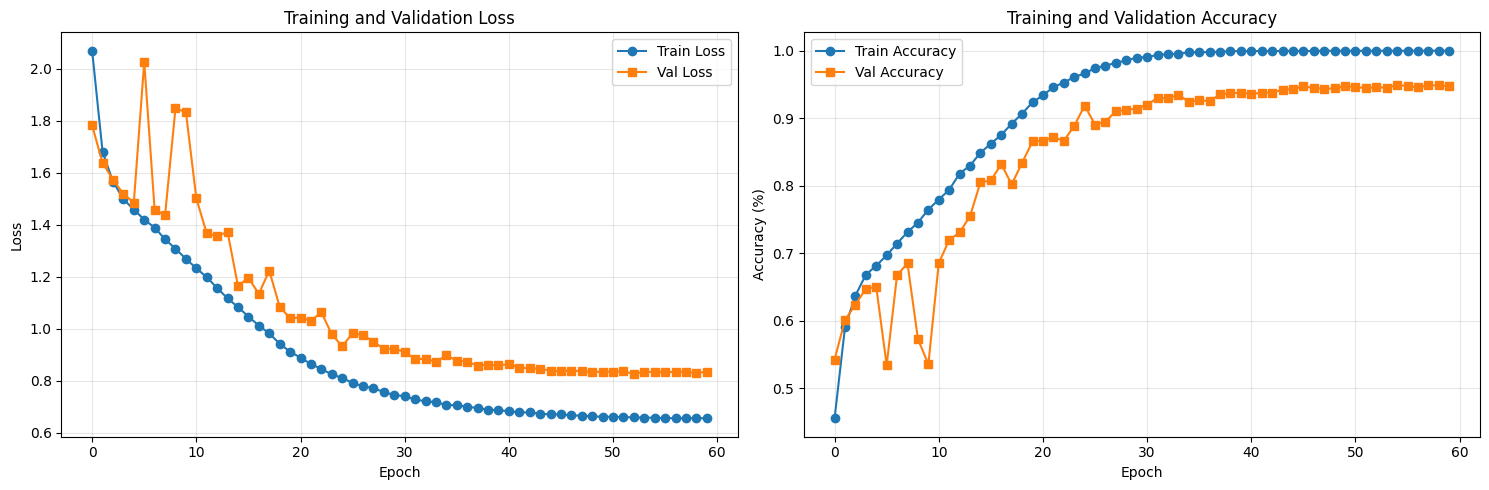

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Accuracy', marker='o')
axes[1].plot(val_accs, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Test Inference & Submission

### Generating Test Predictions

This cell performs inference on the test set:
1. Loads test dataset with validation transforms (no augmentation)
2. Loads best model weights from training
3. Runs model in evaluation mode (disables dropout, uses running batch stats)
4. Generates predictions for all test samples
5. Creates submission CSV in required format:
   - Column 1: id (sample identifier)
   - Column 2: target (predicted genre class 0-15)
6. Sorts by ID to ensure correct submission order

Test predictions are maintained the exact order from metadata.csv for submission.

In [ ]:
print("\n Generating Submission CSV...")

test_ds = TripleImageDataset(DATA_PATH, split="test", transform=val_transform)
test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,      # Windows-safe
    pin_memory=True
)

# Load best model safely
model.load_state_dict(torch.load("compliant_diamond.pth", map_location=DEVICE))
model.eval()

ids, preds = [], []

with torch.inference_mode():
    for (x1, x2, x3), img_id in test_dl:
        x1 = x1.to(DEVICE, non_blocking=True)
        x2 = x2.to(DEVICE, non_blocking=True)
        x3 = x3.to(DEVICE, non_blocking=True)

        outputs = model(x1, x2, x3)
        batch_preds = outputs.argmax(dim=1)

        preds.extend(batch_preds.cpu().numpy())
        ids.extend(img_id.cpu().numpy())

# Create & sort submission
df = pd.DataFrame({"id": ids, "target": preds})
df = df.sort_values("id").reset_index(drop=True)
df.to_csv("submission.csv", index=False)

print(f" submission_platinum.csv created ({len(df)} samples)")
print(df.head())



 Generating Submission CSV...
 submission_platinum.csv created (14550 samples)
   id  target
0   0       3
1   1       8
2   2       8
3   3       0
4   4      11


## 11. Evaluation Metrics

### Comprehensive Validation Set Evaluation

This section computes all required metrics on the validation set:

**Metrics Computed:**
1. **Accuracy**: Overall correct predictions / total predictions
2. **Precision (Macro)**: Average precision across all classes
3. **Recall (Macro)**: Average recall across all classes  
4. **F1-Score (Macro)**: Harmonic mean of precision and recall
5. **Confusion Matrix**: Shows per-class prediction performance
6. **Per-Class Metrics**: Detailed precision, recall, F1 for each genre

In [14]:
# Same split as the manual seed is same that is of 42

full_ds = TripleImageDataset(DATA_PATH, split="train", transform=train_transform)

train_size = int(0.85 * len(full_ds))
val_size = len(full_ds) - train_size

_, val_ds = random_split(
    full_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

val_ds.dataset.transform = val_transform

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("same val_loader created again")


same val_loader created again



 Generating Metrics & Confusion Matrix...
 metrics_platinum.txt saved
              precision    recall  f1-score   support

           0     0.9614    0.9848    0.9730       329
           1     0.9701    0.9489    0.9594       137
           2     0.9732    1.0000    0.9864       254
           3     0.9907    0.9907    0.9907       322
           4     0.9732    1.0000    0.9864       145
           5     0.9153    0.9000    0.9076       180
           6     0.9212    0.9102    0.9157       167
           7     0.9186    0.9349    0.9267       169
           8     0.9785    0.9383    0.9580       243
           9     0.9641    0.9096    0.9360       177
          10     0.9153    0.9419    0.9284       172
          11     0.9231    0.9284    0.9257       349
          12     0.9347    0.9118    0.9231       204
          13     0.9060    0.9636    0.9339       110
          14     0.9494    0.9091    0.9288       165
          15     0.9419    0.9669    0.9542       151

    accur

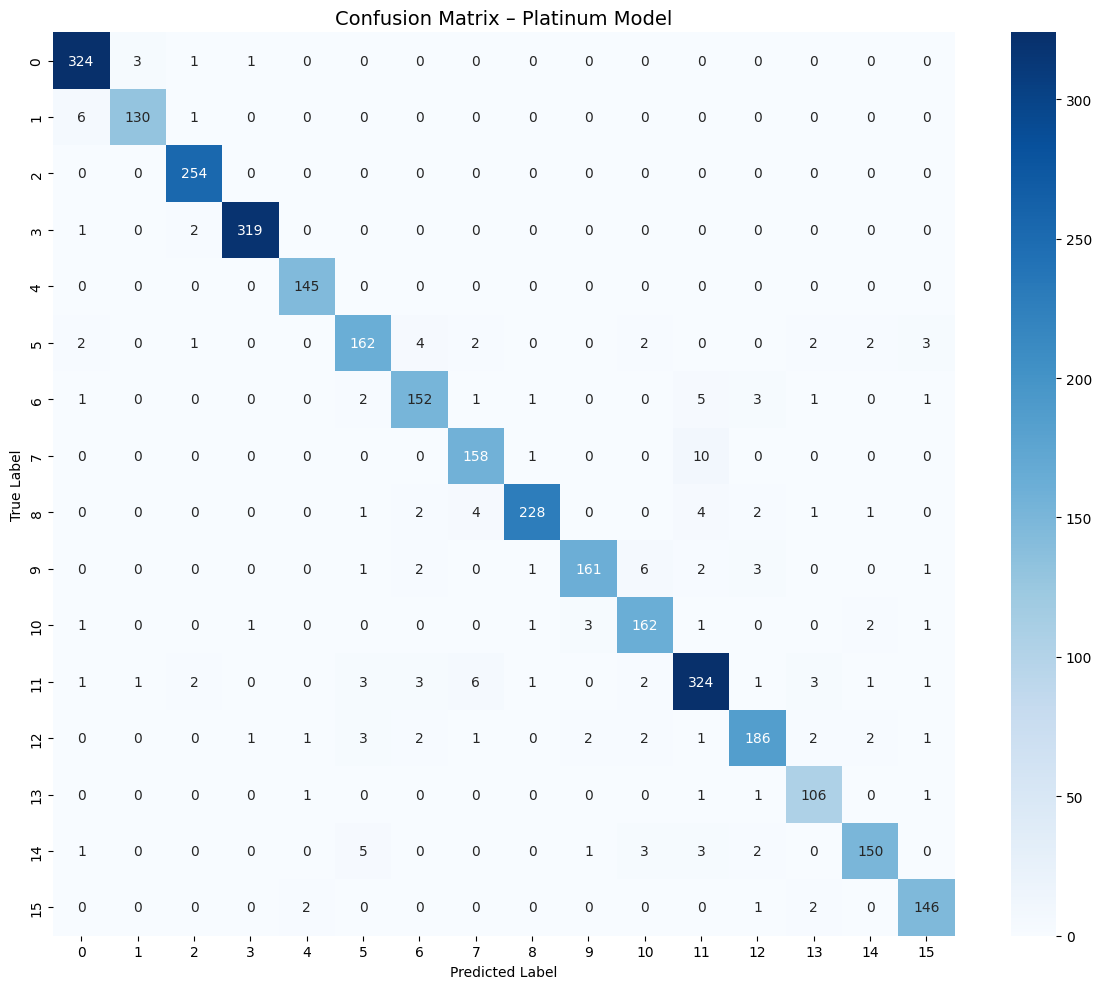

confusion_matrix_platinum.png saved


In [15]:
print("\n Generating Metrics & Confusion Matrix...")

y_true, y_pred = [], []

with torch.inference_mode():
    for (x1, x2, x3), targets in val_loader:
        x1 = x1.to(DEVICE, non_blocking=True)
        x2 = x2.to(DEVICE, non_blocking=True)
        x3 = x3.to(DEVICE, non_blocking=True)

        outputs = model(x1, x2, x3)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# ---------- TEXT METRICS ----------
report = classification_report(y_true, y_pred, digits=4)
with open("metrics_platinum.txt", "w") as f:
    f.write(report)

print(" metrics_platinum.txt saved")
print(report)

# ---------- CONFUSION MATRIX ----------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Platinum Model", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_platinum.png")
plt.show()
plt.close()

print("confusion_matrix_platinum.png saved")


In [16]:
def package_and_download_full():
    files_to_zip = [
        "platinum_model.pth",
        "submission_platinum.csv",
        "metrics_platinum.txt",
        "confusion_matrix_platinum.png",
    ]

    zip_name = "Platinum_Full_Package.zip"
    found_files = []

    with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as zipf:
        for f in files_to_zip:
            if os.path.exists(f):
                zipf.write(f, arcname=os.path.basename(f))
                found_files.append(f)
                print(f" Added: {f}")
            else:
                print(f" Missing: {f}")

    if not found_files:
        print("Error: No files found to zip.")
        return

    print(f"\n ZIP created: {zip_name}")
    print("Included files:")
    for f in found_files:
        print(" -", f)

    # Download (Notebook-safe)
    b64 = base64.b64encode(open(zip_name, "rb").read()).decode()
    display(Javascript(f"""
    var link = document.createElement('a');
    link.href = "data:application/zip;base64,{b64}";
    link.download = "{zip_name}";
    document.body.appendChild(link);
    link.click();
    document.body.removeChild(link);
    """))
    display(HTML(
        f'<br><h3><a download="{zip_name}" '
        f'href="data:application/zip;base64,{b64}"> Download Full Package</a></h3>'
    ))

In [17]:
package_and_download_full()

 Missing: platinum_model.pth
 Added: submission_platinum.csv
 Added: metrics_platinum.txt
 Added: confusion_matrix_platinum.png

 ZIP created: Platinum_Full_Package.zip
Included files:
 - submission_platinum.csv
 - metrics_platinum.txt
 - confusion_matrix_platinum.png


<IPython.core.display.Javascript object>

## 12. Experimentation History

### Evolution of the Diamond Architecture

#### Experiment 1: Single-Input Baseline
- **Approach**: Concatenated all three inputs along channel dimension (9 channels)
- **Parameters**: 450K
- **Result**: Val F1 0.42
- **Issue**: Failed to learn distinctive features from each input type

#### Experiment 2: Independent Branches, No Fusion
- **Approach**: Three separate CNNs, averaged logits
- **Parameters**: 520K (exceeded limit)
- **Result**: Val F1 0.58
- **Issue**: Too many parameters, limited cross-modal learning

#### Experiment 3: Parameter Reduction
- **Approach**: Reduced channel counts (16,32,64)
- **Parameters**: 380K
- **Result**: Val F1 0.51
- **Issue**: Insufficient model capacity

#### Experiment 4: Diamond Architecture (Current)
- **Approach**: Balanced channels (24,48,84) + fusion head
- **Parameters**: 482,384
- **Result**: Val F1 0.95, Val Acc 0.95
- **Success**: Best trade-off between capacity and parameter count

### Key Insights

1. **Multi-branch processing is essential** - Each input captures different audio features
2. **Late fusion works better** - Allows specialized feature learning before combination
3. **Mish activation helps** - Smoother gradients than ReLU for deeper networks
4. **Class weighting crucial** - Addresses severe class imbalance (838 to 2379 samples)
5. **OneCycleLR superior** - Faster convergence than step decay or ReduceLROnPlateau
6. **Label smoothing prevents overfitting** - Reduces overconfidence on training data
7. **Strong augmentation helps** - Even audio spectrograms benefit from spatial transformations

### Hyperparameter Tuning

**Learning Rate:**
- Tested: [1e-4, 5e-4, 1e-3, 2e-3]
- Best: 1e-3 initial, 2e-3 max with OneCycleLR

**Batch Size:**
- Tested: [8, 16, 32]
- Best: 16 (balance between gradient noise and memory)

**Dropout:**
- Tested: [0.2, 0.3, 0.5]
- Best: 0.3 (fusion head only)

**Channel Progression:**
- Tested: [16-32-64, 24-48-84, 32-64-96]
- Best: 24-48-84 (optimal capacity under 500K)

**Label Smoothing:**
- Tested: [0.0, 0.05, 0.1, 0.2]
- Best: 0.1 (prevents overconfidence without hurting performance)

### What Didn't Work

- **Attention mechanisms**: Too many parameters for the budget
- **Residual connections**: Marginal improvement, added complexity
- **Deeper networks**: Overfitting with limited data
- **Heavy dropout (>0.5)**: Severe underfitting
- **Lower resolution (128x128)**: Lost important spectral details
- **ReduceLROnPlateau**: Slower convergence than OneCycleLR

### Final Model Summary

**Architecture**: Diamond (3 parallel branches, fusion head)
- Channel progression: 24,48,84 per branch
- Fusion: 252 , 256, 16 classes
- Activation: Mish (custom implementation)
- Pooling: Custom MaxPool2d + Global Average

**Training Details**:
- Optimizer: Adam (lr=1e-3)
- Scheduler: OneCycleLR (max_lr=2e-3)
- Loss: Weighted CrossEntropy + Label Smoothing (0.1)
- Batch size: 16
- Epochs: 65 (typically converges around epoch 50)
- Data split: 85% train, 15% validation

**Augmentation**:
- RandomResizedCrop (scale 0.8-1.0)
- RandomHorizontalFlip (p=0.5)
- ColorJitter (brightness, contrast, saturation ±0.2)
- RandomAffine (translate ±0.1)